**Text Sentiment Analysis**
 -------------------------
 For sentiment analysis we are required to use the sarcasm news dataset. (given an input from the dataset/random input our code should tell if there is sarcasm in it or not.) (two portions in test file. 1 for performance metrics on running on test_set and one for random input from the user to detect sarcasm.)

 ***Author: Muhammad Faizan***



Department of Robotics & AI - School of Mechanical & Manufacturing Engineering, NUST*

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  %tensorflow_version 2.x
except Exception:
  print("Using TensorFlow 1.x version")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%ls

sample_data/


In [3]:
!nvidia-smi

Sat Dec 16 13:39:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# all imports
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# hyperparameters
#-----------------
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [ ]:
# downloading the dataset from the given link in the slides
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


In [7]:
# read json file and separte the headlines from the labels (sarcasm and non sarcasm)
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
print(sentences)
print(len(sentences))

In [9]:
# split into training and teseting sets
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [10]:
# tokenize the sentences such as headlines into words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# words to integers mapping dict
word_index = tokenizer.word_index

# Training: Encode the text into numbers and pad the sequence with the maximum length in the sequence, truncate any longer sentence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Testing: Encode the text into numbers and pad the sequence with the maximum length in the sequence, truncate any longer sentence
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
# get sense what is going on in the dataset
index = 100
print(f'orginal sentence: {training_sentences[index]}')
print(f'Is sarcastic: {training_labels[index]}')
print(f'Encoded sequence: {training_sequences[index]}')
print(f'Padded sequence: {training_padded[index]}')

orginal sentence: demi lovato drops emotional 'nightingale' music vid
Is sarcastic: 0
Encoded sequence: [4843, 4844, 1880, 859, 1, 402, 1]
Padded sequence: [4843 4844 1880  859    1  402    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [12]:
# convert the TensorFlow tensors to numpy arrays
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)


In [13]:
# define the model using Simple MLP
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# train the model on the dataset with 3o epochs and validate on the validation dataset
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6525 - accuracy: 0.6047 - val_loss: 0.5400 - val_accuracy: 0.7541 - 6s/epoch - 10ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4071 - accuracy: 0.8396 - val_loss: 0.3822 - val_accuracy: 0.8362 - 2s/epoch - 4ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2976 - accuracy: 0.8831 - val_loss: 0.3488 - val_accuracy: 0.8548 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 4s - loss: 0.2468 - accuracy: 0.9054 - val_loss: 0.3594 - val_accuracy: 0.8410 - 4s/epoch - 6ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2128 - accuracy: 0.9189 - val_loss: 0.3507 - val_accuracy: 0.8532 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1867 - accuracy: 0.9296 - val_loss: 0.4014 - val_accuracy: 0.8332 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1644 - accuracy: 0.9395 - val_loss: 0.3755 - val_accuracy: 0.8536 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1456 - accuracy: 0.9470 - val_loss: 0.4389 - val_accuracy: 0.8308 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 - 4s

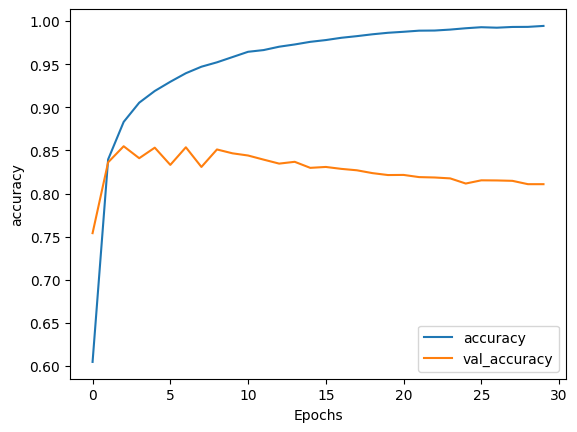

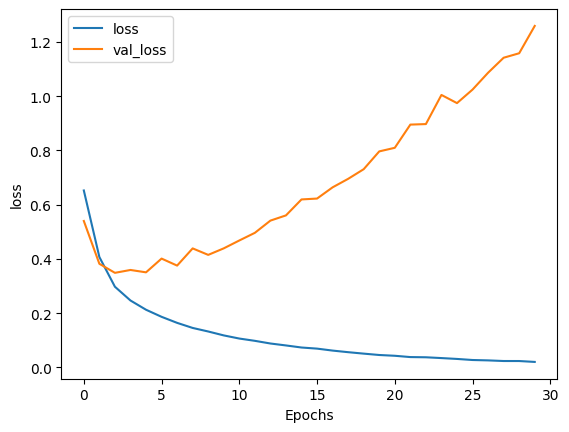

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
# intergers to word mapping for decoding the text
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(labels[0])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
former versace store clerk sues over secret 'black code' for minority shoppers
0


In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [27]:
# SAVE THE WEIGHTS

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [28]:
# DOWNLAOD
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
pred_threshold = 0.5 # vary it to see the impact for better performance
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night",
             "The weather is getting cold", "The quick brown fox jumps over the lazy dog"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(padded).squeeze()

for ind, prediction in enumerate(predictions):
  if float(prediction)>= pred_threshold:
    print(f" {ind + 1} Sarcatic")
  else:
    print(f" {ind + 1} Non Sarcastic")






1/1 [==============================] - 0s 21ms/step
 1 Sarcatic
 2 Non Sarcastic
 3 Non Sarcastic
 4 Non Sarcastic
